In [1]:
!pip install -q langchain langchain_core langchain_community langchain_google_genai langgraph

In [2]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google GenAI API key: ")

Enter your Google GenAI API key: ··········


In [3]:
def print_messages(messages):
    for message in messages["messages"]:
        print(message)

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
chat_google_genai = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0)

In [9]:
from typing import Optional
from langchain_core.tools import tool

@tool
def process_content(
    content: str,
    action: str,
    target_lang: Optional[str] = None,
    source_lang: Optional[str] = None,
    custom_prompt: Optional[str] = None
) -> str:
    """ Tool for processing content """

    action_map = {
        "translate": lambda: [
            ("system", "You are an expert translator."),
            ("human", f"Translate this content from {source_lang or 'unspecified language'} to {target_lang}: '{content}'. Just give me the direct answer.")
        ],
        "summarize": lambda: [
            ("system", "You are an expert summarizer."),
            ("human", f"Summarize the following content: '{content}'. Just give me the direct answer.")
        ],
        "rewrite": lambda: [
            ("system", "You are an expert in rewriting text for clarity and tone."),
            ("human", f"Rewrite the following content for better clarity or tone: '{content}'. Just give me the direct answer.")
        ],
        "question_generation": lambda: [
            ("system", "You are an expert in generating questions."),
            ("human", f"Generate multiple-choice or free-response questions from the following content: '{content}'. Just give me the direct answer.")
        ],
        "custom": lambda: [
            ("system", "You are an expert assistant capable of custom tasks."),
            ("human", custom_prompt)
        ]
    }

    if action not in action_map:
        raise ValueError(f"Invalid action '{action}'. Supported actions are: {list(action_map.keys())}.")
    if action == "translate" and not target_lang:
        raise ValueError("Target language (target_lang) is required for translation.")
    if action == "custom" and not custom_prompt:
        raise ValueError("Custom prompt (custom_prompt) is required for custom actions.")

    messages = action_map[action]()
    response = chat_google_genai.invoke(messages)
    return response.content


In [10]:
tools = [process_content]

In [11]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
  model=ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0),
  tools=tools,
)

In [33]:
from langgraph.graph import StateGraph, MessagesState, START, END

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def route_query(state: MessagesState):
    messages = state["messages"]
    messages_for_genai = [
        ("system", "You are an expert router."),
        ("human", f"""
          Evaluate the appropriate action based on the given message
          {messages[0].content}
          Choose one of the following options:
          - 'translate': If the primary task is translating the text.
          - 'summarize': If the task requires creating a concise summary of the text.
          - 'rewrite': If the task involves rephrasing or improving the text while keeping its meaning.
          - 'question_generation': If the task is to generate questions based on the text.
          - 'custom': Select this if the task is complex, involves multiple actions from the above list, or doesn’t fit any single category.

          Return only the name of the selected action.
        """)
    ]
    result = chat_google_genai.invoke(messages_for_genai)
    print(result.content.strip())
    return {"messages": messages, "action": result.content.strip()}

def call_model(state: MessagesState):
    messages = state["messages"]
    # Pass the messages as a dictionary with a "messages" key to agent.invoke
    response = agent.invoke({"messages": messages, "action": state.get("action")})
    # Ensure the response is a dictionary and has a 'messages' key
    if isinstance(response, dict) and "messages" in response:
        # Update the messages in the state
        updated_messages = messages + response["messages"]
    else:
        # If the response isn't a dictionary or doesn't have 'messages', keep the original messages
        updated_messages = messages
    # Return the updated messages as a dictionary with a "messages" key
    return {"messages": updated_messages}

workflow = StateGraph(MessagesState)
workflow.add_node("router", route_query)
workflow.add_node("agent", call_model)
workflow.add_node("tools", agent)
workflow.add_edge(START, "router")
workflow.add_edge("router", "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

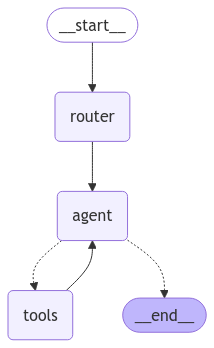

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

#Translation:

In [34]:
input_message = "Texto a traducir"
target_language = "en"
source_language = "es"

for chunk in app.stream(
    {
        "messages": [
            ("human", f"Please, translate '{input_message}' from {source_language} to {target_language}.")
        ]
    },
    stream_mode="values",
):
    print(chunk["messages"][-1].content)

Please, translate 'Texto a traducir' from es to en.
translate
Please, translate 'Texto a traducir' from es to en.
Text to translate.



In [35]:
print_messages(chunk)

content="Please, translate 'Texto a traducir' from es to en." additional_kwargs={} response_metadata={} id='fd65783e-1b61-49fc-97c9-960a74001572'
content='' additional_kwargs={'function_call': {'name': 'process_content', 'arguments': '{"content": "Texto a traducir", "source_lang": "es", "target_lang": "en", "action": "translate"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-41418d5d-7ea5-4a71-a27a-de1ae4f9a856-0' tool_calls=[{'name': 'process_content', 'args': {'content': 'Texto a traducir', 'source_lang': 'es', 'target_lang': 'en', 'action': 'translate'}, 'id': '3d72e0b7-e4b1-4fea-ba85-0daa91594ddc', 'type': 'tool_call'}] usage_metadata={'input_tokens': 118, 'output_tokens': 17, 'total_tokens': 135, 'input_token_details': {'cache_read': 0}}
content='Text to translate.\n' name='process_content' id='615ee74d-161f-4956-bfb1-543d4818d768' tool_call_id='3d72e0b7-e4b1-4fea-ba85-0daa91594ddc'
conten

In [36]:
input_message = """Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language.
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development."""

target_language = "es"
source_language = "en"

for chunk in app.stream(
    {
        "messages": [
            ("human", f"Please, translate '{input_message}' from {source_language} to {target_language}.")
        ]
    },
    stream_mode="values",
):
    print(chunk["messages"][-1].content)

Please, translate 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable 
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned 
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development.' from en to es.
translate
Please, translate 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly transformer architectures, to process 

In [37]:
print_messages(chunk)

content="Please, translate 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. \nThese models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable \nof performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned \nfor specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development.' from en to es." additional_kwargs={} response_metadata={} id='17d9f047-321a-4637-a30a-110c1f3fbbc9'
content='' additional_kwargs={'function_call': {'name': 'process_content', 'arguments': '{"content": "Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast

#Summarization:

In [38]:
input_message = """Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language.
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development."""

for chunk in app.stream(
    {
        "messages": [
            ("human", f"Please, summarize '{input_message}'.")
        ]
    },
    stream_mode="values",
):
    print(chunk["messages"][-1].content)

Please, summarize 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable 
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned 
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development.'.
summarize
Please, summarize 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly transformer architectures, to process and generate t

In [39]:
print_messages(chunk)

content="Please, summarize 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. \nThese models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable \nof performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned \nfor specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development.'." additional_kwargs={} response_metadata={} id='d769104d-8304-4339-8a87-5ec8d21c4b33'
content='Large Language Models (LLMs) are AI systems trained on massive text datasets to understand and generate human-like text.  Using deep learning (transformers), they perform tasks like translation, s

#Custom Tasks:

In [46]:
input_message = """Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language.
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development."""

target_language = "es"
source_language = "en"

for chunk in app.stream(
    {
        "messages": [
            ("human", f"Please, summarize '{input_message}' and then translate that summarization from {source_language} to {target_language}.")
        ]
    },
    stream_mode="values",
):
    print(chunk["messages"][-1].content)

Please, summarize 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly transformer architectures, to process and generate text across a wide range of contexts and tasks. LLMs are capable 
of performing diverse functions, including language translation, summarization, content creation, and even complex problem-solving. Their capabilities continue to expand as they are fine-tuned 
for specific applications, making them invaluable tools in industries such as healthcare, education, customer support, and software development.' and then translate that summarization from en to es.
custom
Please, summarize 'Large Language Models (LLMs) are advanced artificial intelligence systems trained on vast amounts of text data to understand and generate human-like language. 
These models leverage deep learning techniques, particularly tra

In [47]:
chunk["messages"][-1].content

'LLMs are AI systems trained on massive text datasets to understand and generate human-like text. Using deep learning, they perform diverse tasks like translation, summarization, and content creation, finding applications across many industries.  The Spanish translation is: Los modelos lingüísticos grandes (LLM) son sistemas de IA entrenados con conjuntos de datos de texto masivos para comprender y generar texto similar al humano.  Utilizando el aprendizaje profundo, realizan diversas tareas como traducción, resumen y creación de contenido, encontrando aplicaciones en muchas industrias.\n'